# Group Project Report

## Predicting User Knowledge Based on Degree of Exam Performance and Study Time
Katherine Kim, Nari Kim, Ali Manochehri

### Introduction

A user knowledge modeling system is a powerful tool with strong applications for exploring the knowledge of the target audience and creating efficient, personalized systems. It allows for individual content personalization, especially in online-learning environments (Kahraman et al., 2013). Our goal for this project is to predict the user’s knowledge level to optimize web-based adaptive learning environments by addressing the following question: 

**Can we predict the knowledge level of the user based on their degree of study time and exam performance for goal object materials?**

The two variables (degree of study time (STG) and exam performance (PEG)) to be used for our training model were carefully chosen to accurately reflect the level of knowledge of the user. It is known that increased study time leads to higher academic performance (Liu, 2022), while exam performance mirrors the level of knowledge retention, improving the accuracy of our classification training model to identify a user’s knowledge level.

To answer the question, we will be using the ‘User Knowledge Modeling’ dataset. In this dataset, a user’s knowledge status about the subject of electrical DC machines is classified as very low, low, middle, and high. It also includes variables that determine the degree of study time, repetition number, exam performance for related and goal object materials. We will use the degree of study time and exam performance as predictors for the user’s knowledge level.


### Summary of Method Used

We loaded the necessary libraries and imported the User Modeling dataset from the internet to begin exploring our data.
For data wrangling, we created a summary table where we selected the columns STG and PEG as predictors and calculated the mean. Next, we summarized the user knowledge categories using the group_by function with summarize and count = n()  to see if there were any imbalances.

With the processed data in hand, we employed the k-nearest neighbors classification method to predict knowledge levels based on exam performance and study time to answer our main question. We split the data into training and testing sets using a 75/25 split. The model’s recipe took STG and PEG as predictors, and we performed cross-validation with 10 folds.  We incorporated the vfold and tune functions in our workflow, and plot a line graph of accuracy vs. k to determine the optimal k-value.

Then, we inputted the optimal k value into the final model, fit to our data, and finally, predicted on the test data. To visually represent the model's accuracy, we created a bar graph of knowledge levels with two fill options: correct and incorrect predictions.


### Preliminary Exploratory Data Analysis

#### Importing libraries and reading the data

In [1]:
library(tidymodels)
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/nkim0/group_project/main/knowledge_data.csv",
                 show_col_types = FALSE)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.8
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.3     ✔ tibble       3.2.1
✔ ggplot2      3.5.0     ✔ tidyr        1.3.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.2.0

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.2     ✔ stringr   1.5.0

#### Wrangling the data

In [2]:
set.seed(22)

tidy_data_all <- data|>
    select(STG, SCG, STR, LPR, PEG, UNS) |>
    na.omit()

tidy_data_all$UNS <- factor(tidy_data_all$UNS, levels=c("very_low", "Low", "Middle", "High"))

tidy_data <- tidy_data_all |>
    select(STG, PEG, UNS) |>
    filter(UNS!="very_low")

knowledge_split <- initial_split(tidy_data, prop = 0.75, strata = UNS)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)

We removed the very_low category from our data analysis as it had a low amount of data compared to the low, middle, high categories, to ensure the categories are at relatively similar amounts for balanced classification. Omitting this category did not affect our analysis and interpretation of the data in this case because it was not an important class to identify. We already have a low category, which allows us to see the relationship between our predictors (STG and PEG) and three different levels of knowledge (low, middle, high). Additionally, no data columns had missing values. 


#### Summarizing the data

In [3]:
knowledge_prediction_summary <- knowledge_train |>
    group_by(UNS) |>
    summarize(count = n())

mean_table <- knowledge_train |>
    select(STG, PEG) |>
    map_df(mean)

knowledge_prediction_summary 
mean_table

UNS    count
1 Low    62   
2 Middle 66   
3 High   47

STG       PEG      
1 0.3706286 0.4933714

For data wrangling, we created a summary table where we selected the columns STG and PEG as predictors and calculated the mean. Next, we summarized the user knowledge categories using the group_by function with summarize and count = n()  to see if there were any imbalances.

#### Visualizing relationships

As part of our preliminary data exploration, we created the visualization of the dataset by creating a scatter plot between exam performance (PEG) vs. degree of study time (STG). Each data point's color represents its corresponding knowledge level by identifying the trend between low (orange), middle (green), and high (blue) levels. This allowed us to see the relationship between the user’s  knowledge level, exam performance, and study time.

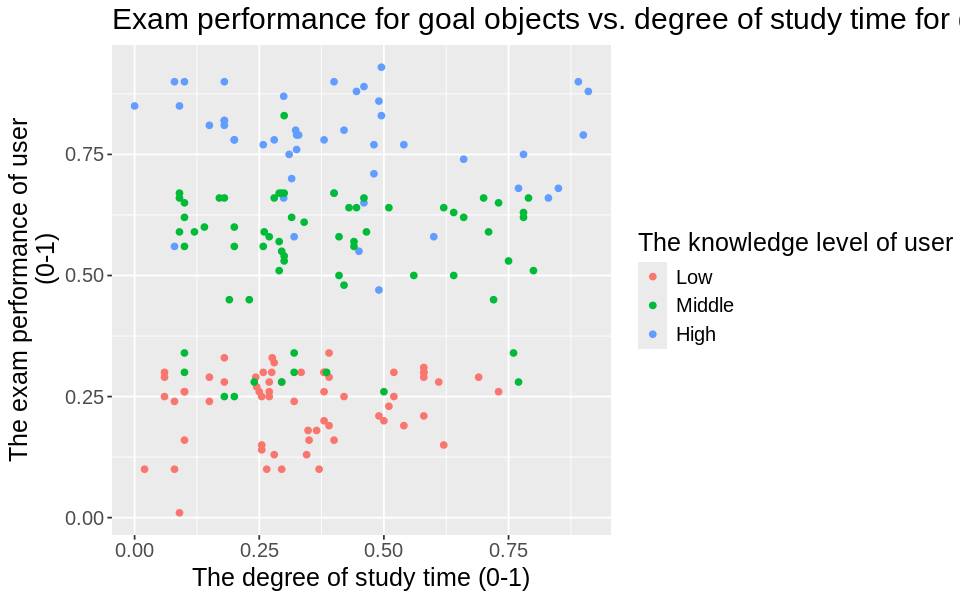

In [4]:
options(repr.plot.height = 5, repr.plot.width = 8)
relation_plot <- knowledge_train |>
    ggplot(aes(x=STG, y=PEG, color=UNS)) +
    geom_point() +
    ggtitle("Exam performance for goal objects vs. degree of study time for goal object material") +
    labs(x="The degree of study time (0-1)", y="The exam performance of user
         (0-1)", color="The knowledge level of user") +
    theme(text=element_text(size=15))

prime_plot <- knowledge_train |> 
    ggplot(aes(fill=UNS)) + labs(fill="The knowledge level of user") + theme(text=element_text(size=15))

STG_distribution <- prime_plot +
    geom_histogram(aes(x=STG), bins=12) +
    ggtitle("Distribution of degree of study time for goal object material") +
    labs(x="Degree of study time (0-1)", y="frequency")

PEG_distribution <- prime_plot +
    geom_histogram(aes(x=STG), bins=12) +
    ggtitle("Distribution of exam performance of user for goal objects") +
    labs(x="Exam performance (0-1)", y="frequency")

relation_plot

#STG_distribution
#PEG_distribution

### Finding the Best K-value
We will find the best k-value by creating a tuning knn model and running the model on training set of 10-fold cross-validation. After fitting the model to the training data, we will collect the metrics of the accuracies and plot the accuracies versus k-value to find the optimum number of neighbors.

→ A | warning: No observations were detected in `truth` for level(s): 'very_low'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x3

There were issues with some computations   A: x9

There were issues with some computations   A: x10





[1] 9

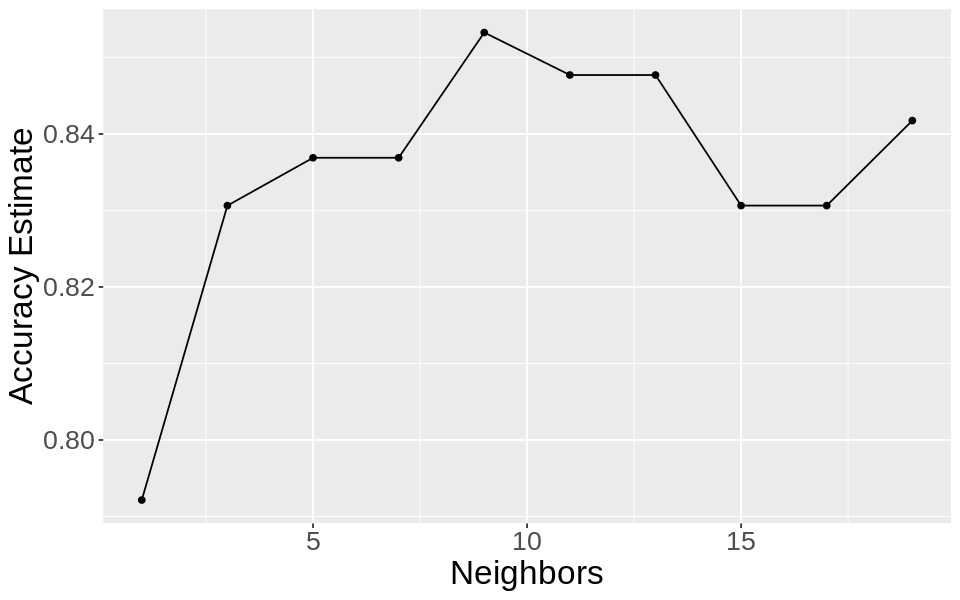

In [32]:
knowledge_recipe <- recipe(UNS ~ STG + PEG, data=knowledge_train)

knowledge_vfold <- vfold_cv(knowledge_train, v = 10, strata = UNS)

knn_tune_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_values <- tibble(neighbors = seq(from=1, to=20, by=2))

knowledge_tune_result <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knn_tune_model) |>
    tune_grid(resamples = knowledge_vfold, grid = k_values) |>
    collect_metrics()

accuracies <- knowledge_tune_result |>
    filter(.metric == 'accuracy')

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() + geom_point() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 20))

best_k <- accuracies |>
    slice_max(mean, n = 1) |>
    pull(neighbors)
    
best_k
cross_val_plot

From the graph of accuracy versus neighbors, we find the best k-value is 9. Using this k-value, we will create the final knn model and fit the data with the model. Using this final fit, we will predict testing data and collect the accuracy.

#### Building our model

In [33]:
knowledge_final_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knowledge_final_fit <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(knowledge_final_model) |>
    fit(data = knowledge_train)

knowledge_final_result <- predict(knowledge_final_fit, knowledge_test) |>
    bind_cols(knowledge_test) |>
    metrics(truth = UNS, estimate = .pred_class)

best_k
knowledge_final_result

[1] 9

.metric  .estimator .estimate
1 accuracy multiclass 0.9322034
2 kap      multiclass 0.8969432

#### Visualization

For visualization of our results, we will create a scatter plot, with the prediction class of each point as the color and the background colour of the graph showing the separation between each class of UNS.

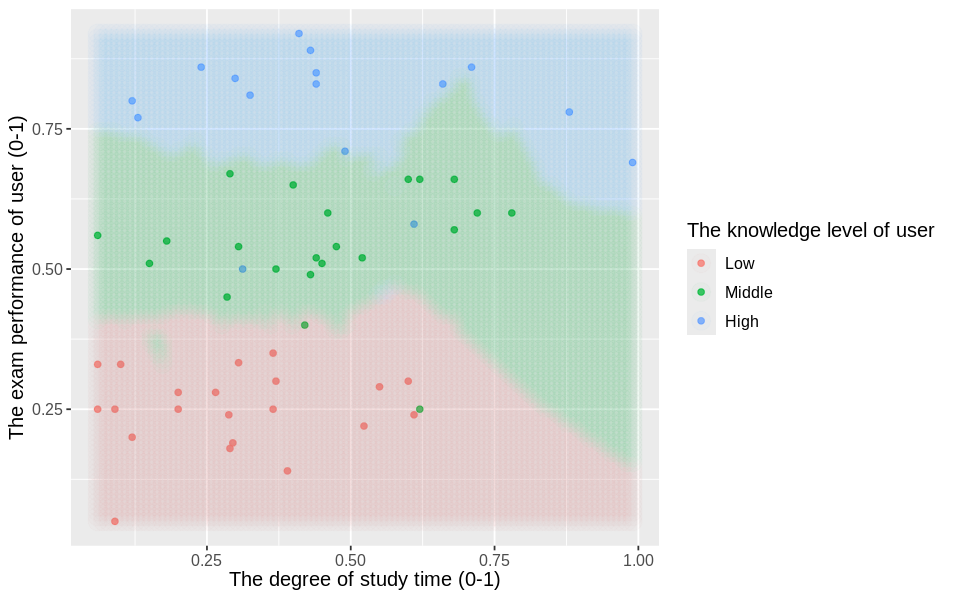

In [49]:
STG_grid <- seq(min(knowledge_test$STG),
                max(knowledge_test$STG),
                length.out = 100)
PEG_grid <- seq(min(knowledge_test$PEG),
                max(knowledge_test$PEG),
                length.out = 100)
spgrid <- as_tibble(expand.grid(STG = STG_grid,
                                PEG = PEG_grid))

knnPredGrid <- predict(knowledge_final_fit, spgrid)

prediction_table <- bind_cols(knnPredGrid, spgrid) |>
  rename(UNS = .pred_class)

UNS_plot <- ggplot() +
  geom_point(data = knowledge_test,
             mapping = aes(x = STG,
                           y = PEG,
                           color = UNS),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = STG,
                           y = PEG,
                           color = UNS),
             alpha = 0.02,
             size = 5) +
  labs(x="The degree of study time (0-1)", 
       y="The exam performance of user (0-1)", 
       color="The knowledge level of user") +
  theme(text = element_text(size = 12))

UNS_plot